# Advanced dynamic seq2seq with TensorFlow

Encoder is bidirectional now. Decoder is implemented using `tf.nn.raw_rnn`. 
It feeds previously generated tokens during training as inputs, instead of target sequence.



regular seq2seq
![seq2seq architecutre](pictures/1-seq2seq.png)
Rectangles are encoder and decoder's recurrent layers. Encoder receives `[A, B, C]` sequence as inputs. We don't care about encoder outputs, only about the hidden state it accumulates while reading the sequence. After input sequence ends, encoder passes its final state to decoder, which receives `[<EOS>, W, X, Y, Z]` and is trained to output `[W, X, Y, Z, <EOS>]`. `<EOS>` token is a special word in vocabulary that signals to decoder the beginning of translation.

## Implementation details

TensorFlow has its own [implementation of seq2seq](https://www.tensorflow.org/tutorials/seq2seq/). Recently it was moved from core examples to [`tensorflow/models` repo](https://github.com/tensorflow/models/tree/master/tutorials/rnn/translate), and uses deprecated seq2seq implementation. Deprecation happened because it uses **static unrolling**.

**Static unrolling** involves construction of computation graph with a fixed sequence of time step. Such a graph can only handle sequences of specific lengths. One solution for handling sequences of varying lengths is to create multiple graphs with different time lengths and separate the dataset into this buckets.

**Dynamic unrolling** instead uses control flow ops to process sequence step by step. In TF this is supposed to more space efficient and just as fast. This is now a recommended way to implement RNNs.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import helpers #for formatting data into batches and generating random sequence data
from ocr.datahelpers import loadWordsData
import time

tf.reset_default_graph()
sess = tf.InteractiveSession()
print('Tensorflow', tf.__version__)

Tensorflow 1.1.0


### Loading images

In [2]:
images, labels, _ = loadWordsData()

Loading words...
Number of Images: 721


In [3]:
CHARS = ['A', 'a', 'Á', 'á', 'B', 'b', 'C', 'c', 'Č', 'č',
         'D', 'd', 'Ď', 'ď', 'E', 'e', 'É', 'é', 'Ě', 'ě',
         'F', 'f', 'G', 'g', 'H', 'h', 'I', 'i', 'Í', 'í',         
         'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n',
         'Ň', 'ň', 'O', 'o', 'Ó', 'ó', 'P', 'p', 'Q', 'q',
         'R', 'r', 'Ř', 'ř', 'S', 's', 'Š', 'š', 'T', 't',
         'Ť', 'ť', 'U', 'u', 'Ú', 'ú', 'Ů', 'ů', 'V', 'v',
         'W', 'w', 'X', 'x', 'Y', 'y', 'Ý', 'ý', 'Z', 'z',
         'Ž', 'ž']

char_size = len(CHARS)

idxs = [i+2 for i in range(char_size)]
idx_to_chars = dict(zip(idxs, CHARS))
chars_to_idx = dict(zip(CHARS, idxs))

labels_idx = np.empty(len(labels), dtype=object)
for i, label in enumerate(labels):
    labels_idx[i] = [chars_to_idx[c] for c in label]
    
print(labels[:5])
print(labels_idx[:5])
print("Number of chars:", char_size)

['A', 'A', 'A', 'David', 'Do']
[[2] [2] [2] [12, 3, 71, 29, 13] [12, 45]]
Number of chars: 82


In [4]:
PAD = 0   # Padding
EOS = 1   # End of seq

N_INPUT = 30*60
vocab_size = char_size + 2    # Number of different chars + <PAD> and <EOS>
input_embedding_size = 40     # Size of vector for embedding chars2vec

encoder_hidden_units = 60     # num neurons 
decoder_hidden_units = 120

In [5]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self, images, targets, num_buckets=5, slider=(60, 30)):
        # First PADDING of images to slider size ( -(a // b) ==  ceil(a/b))
        self.slider = slider
        for i in images:
            i.resize((i.shape[0], -(-i.shape[1] // slider[1]) * slider[1]),
                     refcheck=False)
        in_length = [image.shape[1]//slider[1] for image in images]
        # Split images to sequence of vectors
        imgseq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            imgseq[i] = [img[:, loc*slider[1]:(loc+1)*slider[1]].flatten()
                         for loc in range(in_length[i])]
        
        # Add EOS symbol to each output sequence
        for t in targets:
            t.append(EOS)           
        # Create pandas dataFrame and sort it by images width (length) 
        self.dataFrame = pd.DataFrame({'in_length': in_length,
                                       'out_length': [len(t) for t in targets],
                                       'images': imgseq,
                                       'targets': targets
                                      }).sort_values('in_length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        self.buckets = []
        # Create buckets by slicing parts by indexes
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket*bsize:(bucket+1)*bsize-1])
        self.buckets.append(self.dataFrame.iloc[num_buckets-1*bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.epochs = 0
        self.shuffle()
        print("Iterator created.")

    def shuffle(self):
        """ Shuffle each bucket separately"""
        for i in range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0

    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        if np.any(self.cursor + batch_size >= self.buckets_size):
            self.epochs += 1
            self.shuffle()

        i_bucket = np.random.randint(0, self.num_buckets)

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        input_max = max(res['in_length'])
        output_max = max(res['out_length'])
        assert input_max + 10 >= output_max   # In order to make it work
        
        input_seq = np.zeros((batch_size, input_max, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['in_length'].values[i]] = img
        input_seq = input_seq.swapaxes(0, 1)
        
        # Need to pad according to the input size
        targets = np.zeros([batch_size, input_max+10], dtype=np.int32)
        for i, target in enumerate(targets):
            target[:res['out_length'].values[i]] = res['targets'].values[i]
        targets = targets.swapaxes(0, 1)
        
        return input_seq, targets, res['in_length'].values, res['out_length'].values


# Create iterator for feeding RNN
# Create only once, it modifies: labels_idx
iterator = BucketDataIterator(images, labels_idx)

Iterator created.


In [6]:
iterator.next_batch(64)[2].shape

(64,)

Nice way to understand complicated function is to study its signature - inputs and outputs. With pure functions, only inputs-output relation matters.

- `encoder_inputs` int32 tensor is shaped `[encoder_max_time, batch_size]`
- `decoder_targets` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [7]:
#input placehodlers
# N_INPUT -> size of vector representing one image in sequence
encoder_inputs = tf.placeholder(shape=(None, None, N_INPUT), dtype=tf.float32, name='encoder_inputs')
#contains the lengths for each of the sequence in the batch, we will pad so all the same
#if you don't want to pad, check out dynamic memory networks to input variable length sequences
encoder_inputs_length = tf.placeholder(shape=(None), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

 Here we implement decoder with `tf.nn.raw_rnn` and will construct `decoder_inputs` step by step in the loop.

### Embeddings

`encoder_inputs` and `decoder_inputs` are int32 tensors of shape `[max_time, batch_size]`, while encoder and decoder RNNs expect dense vector representation of words, `[max_time, batch_size, input_embedding_size]`. We convert one to another by using *word embeddings*. Specifics of working with embeddings are nicely described in [official tutorial on embeddings](https://www.tensorflow.org/tutorials/word2vec/).

First we initialize embedding matrix. Initializations are random. We rely on our end-to-end training to learn vector representations for words jointly with encoder and decoder.

In [8]:
#randomly initialized embedding matrrix that can fit input sequence
#used to convert sequences to vectors (embeddings) for both encoder and decoder of the right size
#reshaping is a thing, in TF you gotta make sure you tensors are the right shape (num dimensions)

# TODO we don't need embedding of input just output...
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

#this thing could get huge in a real world application
# encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
# TODO Delete inputs embedding

We use `tf.nn.embedding_lookup` to *index embedding matrix*: given word `4`, we represent it as 4th column of embedding matrix. 
This operation is lightweight, compared with alternative approach of one-hot encoding word `4` as `[0,0,0,1,0,0,0,0,0,0]` (vocab size 10) and then multiplying it by embedding matrix.

Additionally, we don't need to compute gradients for any columns except 4th.

In real NLP application embedding matrix can get very large, with 100k or even 1m columns.

## Encoder

We are replacing unidirectional `tf.nn.dynamic_rnn` with `tf.nn.bidirectional_dynamic_rnn` as the encoder.


In [9]:
from tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl import LSTMCell, LSTMStateTuple

In [10]:
enc_cell_fw = LSTMCell(num_units=encoder_hidden_units,
                       state_is_tuple=True)
enc_cell_bw = LSTMCell(num_units=encoder_hidden_units,
                       state_is_tuple=True)

In [11]:
#get outputs and states
#bidirectional RNN function takes a separate cell argument for 
#both the forward and backward RNN, and returns separate 
#outputs and states for both the forward and backward RNN

#When using a standard RNN to make predictions we are only taking the “past” into account. 
#For certain tasks this makes sense (e.g. predicting the next word), but for some tasks 
#it would be useful to take both the past and the future into account. Think of a tagging task, 
#like part-of-speech tagging, where we want to assign a tag to each word in a sentence. 
#Here we already know the full sequence of words, and for each word we want to take not only the 
#words to the left (past) but also the words to the right (future) into account when making a prediction. 
#Bidirectional RNNs do exactly that. A bidirectional RNN is a combination of two RNNs – one runs forward from 
#“left to right” and one runs backward from “right to left”. These are commonly used for tagging tasks, or 
#when we want to embed a sequence into a fixed-length vector (beyond the scope of this post).


((encoder_fw_outputs, encoder_bw_outputs),
 (encoder_fw_final_state, encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw = enc_cell_fw,
                                    cell_bw = enc_cell_bw,
                                    inputs = encoder_inputs,
                                    sequence_length = encoder_inputs_length,
                                    dtype = tf.float32,
                                    time_major = True))

In [12]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 60) dtype=float32>

In [13]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 60) dtype=float32>

In [14]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 60) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 60) dtype=float32>)

In [15]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 60) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 60) dtype=float32>)

Have to concatenate forward and backward outputs and state. In this case we will not discard outputs, they would be used for attention.

In [16]:
#Concatenates tensors along one dimension.
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

#letters h and c are commonly used to denote "output value" and "cell state". 
#http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
#Those tensors represent combined internal state of the cell, and should be passed together. 

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

## Decoder

In [17]:
decoder_cell = LSTMCell(num_units=decoder_hidden_units,
                        state_is_tuple=True)

Time and batch dimensions are dynamic, i.e. they can change in runtime, from batch to batch
 When decoding, feeding previously generated tokens as inputs adds robustness to model's errors. However feeding ground truth speeds up training. Apperantly best practice is to mix both randomly when training.


In [18]:
#we could print this, won't need
encoder_max_time, batch_size, _ = tf.unstack(tf.shape(encoder_inputs))

Next we need to decide how far to run decoder. There are several options for stopping criteria:
- Stop after specified number of unrolling steps
- Stop after model produced <EOS> token

The choice will likely be time-dependant. In legacy `translate` tutorial we can see that decoder unrolls for `len(encoder_input)+10` to allow for possibly longer translated sequence. Here we are doing a toy copy task, so how about we unroll decoder for `len(encoder_input)+2`, to allow model some room to make mistakes over 2 additional steps:

In [19]:
# TODO additional steps depending on input image size
decoder_lengths = encoder_inputs_length + 10
# seq2seq example uses  +10 steps,
# +9 additional steps, +1 leading <EOS> token for decoder inputs

## Output projection

Decoder will contain manually specified by us transition step:
```
output(t) -> output projection(t) -> prediction(t) (argmax) -> input embedding(t+1) -> input(t+1)
```

In tutorial 1, we used `tf.contrib.layers.linear` layer to initialize weights and biases and apply operation for us. This is convenient, however now we need to specify parameters `W` and `b`  of the output layer in global scope, and apply them at every step of the decoder.

In [20]:
#manually specifying since we are going to implement attention details for the decoder in a sec
#weights
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

## Decoder via `tf.nn.raw_rnn`

`tf.nn.dynamic_rnn` allows for easy RNN construction, but is limited. 

For example, a nice way to increase robustness of the model is to feed as decoder inputs tokens that it previously generated, instead of shifted true sequence.

![seq2seq-feed-previous](pictures/2-seq2seq-feed-previous.png)
*Image borrowed from http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/*

First prepare tokens. Decoder would operate on column vectors of shape `(batch_size,)` representing single time steps of the batch.

In [21]:
#create padded inputs for the decoder from the word embeddings

#were telling the program to test a condition, and trigger an error if the condition is false.
assert EOS == 1 and PAD == 0

pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')
eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')


#retrieves rows of the params tensor. The behavior is similar to using indexing with arrays in numpy
eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

Now for the tricky part.

Remember that standard `tf.nn.dynamic_rnn` requires all inputs `(t, ..., t+n)` be passed in advance as a single tensor. "Dynamic" part of its name refers to the fact that `n` can change from batch to batch.

Now, what if we want to implement more complex mechanic like when we want decoder to receive previously generated tokens as input at every timestamp (instead of lagged target sequence)? Or when we want to implement soft attention, where at every timestep we add additional fixed-len representation, derived from query produced by previous step's hidden state? `tf.nn.raw_rnn` is a way to solve this problem.

Main part of specifying RNN with `tf.nn.raw_rnn` is *loop transition function*. It defines inputs of step `t` given outputs and state of step `t-1`.

Loop transition function is a mapping `(time, previous_cell_output, previous_cell_state, previous_loop_state) -> (elements_finished, input, cell_state, output, loop_state)`. It is called *before* RNNCell to prepare its inputs and state. Everything is a Tensor except for initial call at time=0 when everything is `None` (except `time`).

Note that decoder inputs are returned from the transition function but passed into it. You are supposed to index inputs manually using `time` Tensor.

Loop transition function is called two times:
 1. Initial call at time=0 to provide initial cell_state and input to RNN.
 2. Transition call for all following timesteps where you define transition between two adjacent steps.

Lets define both cases separately.

Loop initial state is function of only `encoder_final_state` and embeddings:

In [22]:
#manually specifying loop function through time - to get initial cell state and input to RNN
#normally we'd just use dynamic_rnn, but lets get detailed here with raw_rnn

#we define and return these values, no operations occur here
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    #end of sentence
    initial_input = eos_step_embedded
    #last time steps cell state
    initial_cell_state = encoder_final_state
    #none
    initial_cell_output = None
    #none
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

Define transition function such that previously generated token (as judged in greedy manner by `argmax` over output projection) is passed as next input.

In [23]:
#attention mechanism --choose which previously generated token to pass as input in the next timestep
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    
    def get_next_input():
        #dot product between previous ouput and weights, then + biases
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        #Logits simply means that the function operates on the unscaled output of 
        #earlier layers and that the relative scale to understand the units is linear. 
        #It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities 
        #(you might have an input of 5).
        #prediction value at current time step
        
        #Returns the index with the largest value across axes of a tensor.
        prediction = tf.argmax(output_logits, axis=1)
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    # Implementing to stop on <EOS>
    #output_logits = tf.add(tf.matmul(previous_output, W), b)
    #prediction = tf.argmax(output_logits, axis=1)
    elements_finished = (time >= decoder_lengths)
    #                          prediction == EOS or
    #                          prediction == PAD) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    
    
    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

Combine initializer and transition functions and create raw_rnn.

Note that while all operations above are defined with TF's control flow and reduction ops, here we rely on checking if state is `None` to determine if it is an initializer call or transition call. This is not very clean API and might be changed in the future (indeed, `tf.nn.raw_rnn`'s doc contains warning that API is experimental).

In [24]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [25]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 120) dtype=float32>

To do output projection, we have to temporarilly flatten `decoder_outputs` from `[max_steps, batch_size, hidden_dim]` to `[max_steps*batch_size, hidden_dim]`, as `tf.matmul` needs rank-2 tensors at most.

In [26]:
#to convert output to human readable prediction
#we will reshape output tensor

#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#reduces dimensionality
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [27]:
#final prediction
decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`. `vocab_size` part of the shape is static, while `max_time` and `batch_size` is dynamic.

In [28]:
#cross entropy loss
#one hot encode the target values so we don't rank just differentiate
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)

In [29]:
sess.run(tf.global_variables_initializer())

## Training on the toy task

Consider the copy task — given a random sequence of integers from a `vocabulary`, learn to memorize and reproduce input sequence. Because sequences are random, they do not contain any structure, unlike natural language.

In [30]:
batch_size = 64

In [31]:
def next_feed():
    (encoder_inputs_,
     decoder_targets_,
     encoder_input_lengths_,
     _) = iterator.next_batch(batch_size)
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_
    }

In [33]:
loss_track = []

In [34]:
max_batches = 5001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[decoder_targets].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 3.874727964401245
  sample 1:
    input     > [33 29  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [28  0  0  0  0  0 69 11 11 11 11 11 79 76]
  sample 2:
    input     > [61 79 37  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [34 46 34  6  6  6  6  6  6 78 10 64 56 74]
  sample 3:
    input     > [61 77 11  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [55 30 30 10 10 69  0  0 69 21 21 21 21 21]

batch 1000
  minibatch loss: 1.4880849123001099
  sample 1:
    input     > [71 45 53  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [71  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  sample 2:
    input     > [49 55 29 53 45 81 17 41 19 27 45  1  0  0  0  0  0  0  0  0  0]
    predicted > [49 53 53 45 45 45 45 41 45  1  0  0  0  0  0  0  0  0  0  0  0]
  sample 3:
    input     > [75 35 53  5 61  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [57 45 35 37  1  1  0  0  0  0  0  0  0  0  0  0  0  0

loss 0.0370 after 320064 examples (batch_size=64)


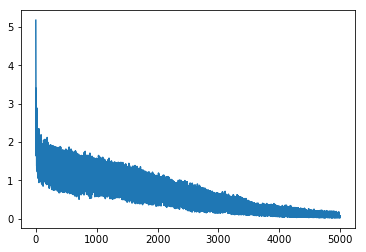

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))